# Notes for user:

*   This notebook will use the dataset COVID-19 and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? USD/GBP (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to the GBP.
*   Therefore, we look at the death rates in the US and the UK.
*   To do: x_train and validation dataset


In [66]:
# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8ayrvxq1
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-8ayrvxq1
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0fb9009c3d4e2befd0500d05a139a63a94a067772_-cp36-none-any.whl size=126414 sha256=f5ddb719e3aa353cc59b2812914d266271b32f1792c6371992b44377df02bb3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-q9m_x0d6/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [67]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [69]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Data Collection


In [70]:
# Importing covid_dataset using pandas. Droping null values.
covid_dataset_data= pd.read_csv('covid.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
# covid_dataset = covid_dataset.dropna()
covid_dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [71]:
# Trying to isolate location/country based on currency in question
# We are looking at pound and sterling therefore need to isolate 'United Kingdom' & 'United States' in location column
# Problem: Informaiton prints up until 'Trinidad and Tobago' for some reason – can print 'Togo'. Therefore cannot print United Kingdom or United States
us_death_rates = covid_dataset.loc[covid_dataset.location=='United States', ['location', 'date', 'total_deaths', 'total_cases', 'cvd_death_rate']]
us_death_rates.head()

,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,2019-12-31,0.0,0.0,151.089
26491,United States,2020-01-01,0.0,0.0,151.089
26492,United States,2020-01-02,0.0,0.0,151.089
26493,United States,2020-01-03,0.0,0.0,151.089
26494,United States,2020-01-04,0.0,0.0,151.089


In [72]:
# us_death_rates = covid_dataset.loc[covid_dataset.location=='Zimbabwe', ['location', 'date', 'total_deaths','total_cases','cvd_death_rate']]
# us_death_rates.head()

In [73]:
us_death_rates.shape

(187, 5)

In [74]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()


# Data Preprocessing / Data Cleaning & Collating

In [75]:
# Filter dataset
forex_dataset.pop('Open')
forex_dataset.pop('High')
forex_dataset.pop('Low')
forex_dataset.pop('Change %')

0       0.12%
1      -0.05%
2       0.59%
3       0.83%
4      -0.30%
        ...  
150    -0.15%
151     0.40%
152     0.85%
153     0.44%
154     0.02%
Name: Change %, Length: 155, dtype: object

In [76]:
forex_dataset.tail()

,Date,Price
150,"Dec 06, 2019",1.3137
151,"Dec 05, 2019",1.3157
152,"Dec 04, 2019",1.3104
153,"Dec 03, 2019",1.2994
154,"Dec 02, 2019",1.2937


In [77]:
# Isolate covid_date
import time 
us_date = us_death_rates['date']
new_us_dates = [time.strptime(x.replace("-"," "), '%Y %m %d')for x in us_date]
us_death_rates['date'] = new_us_dates
us_death_rates.head()


,location,date,total_deaths,total_cases,cvd_death_rate
26490,United States,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",0.0,0.0,151.089
26491,United States,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",0.0,0.0,151.089
26492,United States,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",0.0,0.0,151.089
26493,United States,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",0.0,0.0,151.089
26494,United States,"(2020, 1, 4, 0, 0, 0, 5, 4, -1)",0.0,0.0,151.089


In [78]:
# Isolate forex_date
import time 
forex_date = forex_dataset['Date']
new_forex_dates = [time.strptime(x.replace(',', ""), '%b %d %Y')for x in forex_date]
forex_dataset['Date'] = new_forex_dates
forex_dataset.tail()


,Date,Price
150,"(2019, 12, 6, 0, 0, 0, 4, 340, -1)",1.3137
151,"(2019, 12, 5, 0, 0, 0, 3, 339, -1)",1.3157
152,"(2019, 12, 4, 0, 0, 0, 2, 338, -1)",1.3104
153,"(2019, 12, 3, 0, 0, 0, 1, 337, -1)",1.2994
154,"(2019, 12, 2, 0, 0, 0, 0, 336, -1)",1.2937


In [79]:
print(len(forex_dataset))

155


In [80]:
# Merging dates from two tables
dataset = pd.merge(left=forex_dataset, left_on='Date',
         right=us_death_rates, right_on='date')
dataset.tail()
len(dataset)


134

In [81]:
# We pop the 'date' from the covid_dataset because this column starts later than the forex column
# We want to see the forex price before covid happened
dataset.pop('date')

0        (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1        (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2        (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3       (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4       (2020, 6, 29, 0, 0, 0, 0, 181, -1)
                      ...                 
129        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
130        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
131        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
132        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
133    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: date, Length: 134, dtype: object

In [82]:
# Problem: This still starts at 2019,12,13 when we want 2019,12,02
# However this does not affect our data graph for some reason - scroll down
dataset.tail()

,Date,Price,location,total_deaths,total_cases,cvd_death_rate
129,"(2020, 1, 6, 0, 0, 0, 0, 6, -1)",1.3169,United States,0.0,0.0,151.089
130,"(2020, 1, 3, 0, 0, 0, 4, 3, -1)",1.3088,United States,0.0,0.0,151.089
131,"(2020, 1, 2, 0, 0, 0, 3, 2, -1)",1.3146,United States,0.0,0.0,151.089
132,"(2020, 1, 1, 0, 0, 0, 2, 1, -1)",1.3255,United States,0.0,0.0,151.089
133,"(2019, 12, 31, 0, 0, 0, 1, 365, -1)",1.3261,United States,0.0,0.0,151.089


In [83]:
# Object means string
dataset['total_deaths']

0      128740.0
1      128062.0
2      127410.0
3      126140.0
4      125804.0
         ...   
129         0.0
130         0.0
131         0.0
132         0.0
133         0.0
Name: total_deaths, Length: 134, dtype: float64

In [84]:
# View what date looks like
date = dataset['Date']
date.head()
len(date)

134

In [85]:
# Splitting timestamp and isolating the date
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', periods=len(date))})
# dateFormatting['new_date'] = [d.date() for d in dateFormatting['my_timestamp']]
# dateFormatting['new_time'] = [d.time() for d in dateFormatting['my_timestamp']]
print(dateFormatting)


      new_date
0   2019-12-31
1   2020-01-01
2   2020-01-02
3   2020-01-03
4   2020-01-04
..         ...
129 2020-05-08
130 2020-05-09
131 2020-05-10
132 2020-05-11
133 2020-05-12

[134 rows x 1 columns]


In [86]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
print(my_xticks)

[Timestamp('2019-12-31 00:00:00'), Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-03 00:00:00'), Timestamp('2020-01-04 00:00:00'), Timestamp('2020-01-05 00:00:00'), Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-07 00:00:00'), Timestamp('2020-01-08 00:00:00'), Timestamp('2020-01-09 00:00:00'), Timestamp('2020-01-10 00:00:00'), Timestamp('2020-01-11 00:00:00'), Timestamp('2020-01-12 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-14 00:00:00'), Timestamp('2020-01-15 00:00:00'), Timestamp('2020-01-16 00:00:00'), Timestamp('2020-01-17 00:00:00'), Timestamp('2020-01-18 00:00:00'), Timestamp('2020-01-19 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-21 00:00:00'), Timestamp('2020-01-22 00:00:00'), Timestamp('2020-01-23 00:00:00'), Timestamp('2020-01-24 00:00:00'), Timestamp('2020-01-25 00:00:00'), Timestamp('2020-01-26 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-01-28 00:00:00'), Timestamp('20

In [87]:
dataset['Date']

0        (2020, 7, 3, 0, 0, 0, 4, 185, -1)
1        (2020, 7, 2, 0, 0, 0, 3, 184, -1)
2        (2020, 7, 1, 0, 0, 0, 2, 183, -1)
3       (2020, 6, 30, 0, 0, 0, 1, 182, -1)
4       (2020, 6, 29, 0, 0, 0, 0, 181, -1)
                      ...                 
129        (2020, 1, 6, 0, 0, 0, 0, 6, -1)
130        (2020, 1, 3, 0, 0, 0, 4, 3, -1)
131        (2020, 1, 2, 0, 0, 0, 3, 2, -1)
132        (2020, 1, 1, 0, 0, 0, 2, 1, -1)
133    (2019, 12, 31, 0, 0, 0, 1, 365, -1)
Name: Date, Length: 134, dtype: object

# Plotting Features before Normalisation

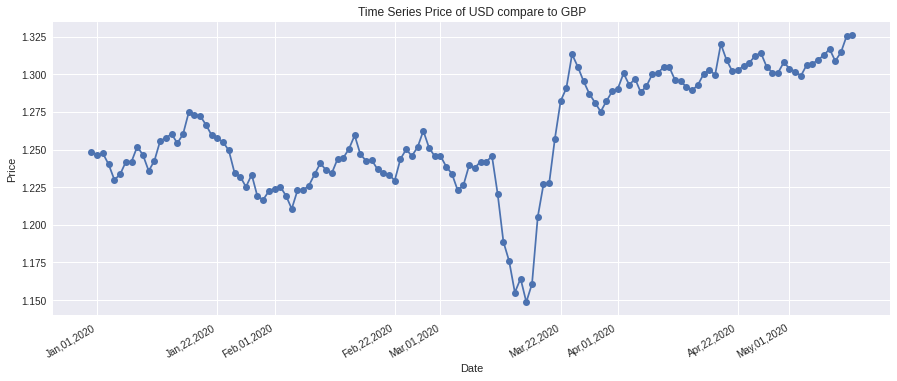

In [88]:
# Plotted prices and dates
# Notice how the dates start and end

from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of USD compare to GBP')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

In [89]:
# print(price)
test = np.array(dataset['total_deaths'])
# print(test)
price.shape
# test.shape
test = np.array(dataset['total_deaths'])
list_arr = np.array(test)
reversed_arr = list_arr[::-1]
reversed_arr.shape
price.shape

(134,)

In [90]:
# Adds the accumulative deaths every day of a country
# Problem – This needs to be sorted from the end since the way out data is set up - can this be made more efficient?
total_us_deaths = dataset['total_deaths']
list_arr = np.array(total_us_deaths)
reversed_arr = list_arr[::-1]
newDay = 0
day = []
for currentday in reversed_arr:
   newDay = currentday + newDay
   day.append(newDay)


Text(0, 0.5, 'Total Deaths')

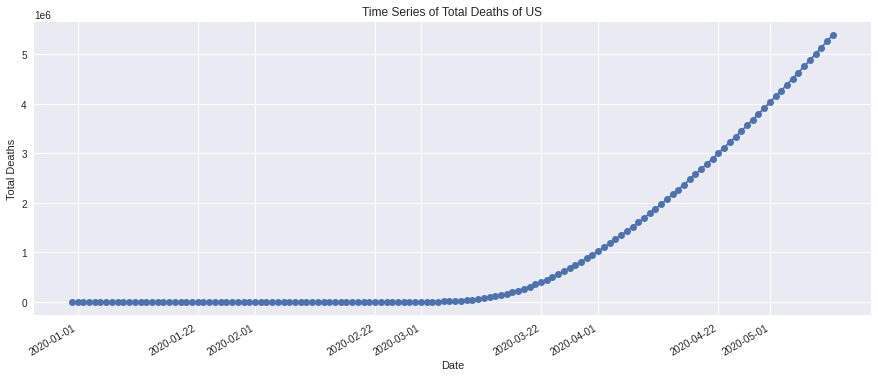

In [91]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
us_deaths = np.array(day)
plt.plot_date(dates,us_deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of US')
plt.xlabel('Date')
plt.ylabel('Total Deaths')


In [92]:
test.shape

(134,)

In [93]:
price.shape

(134,)

In [94]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([day]), columns= ["Total_Deaths_US"])
# print(price_frame)
# print(death_frame)
# problem: not correct
price_frame.append(death_frame)

,Price,Total_Deaths_US
0,1.2482,NaN
1,1.2467,NaN
2,1.2474,NaN
3,1.2401,NaN
4,1.2299,NaN
...,...,...
129,NaN,4881974.0
130,NaN,5008114.0
131,NaN,5135524.0
132,NaN,5263586.0


# Normalisation of Features

In [ ]:
# Working Normalised method!!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# they are so small that is why
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
# loosing precision by converting to decimal but makes more readable
# but when plotting it use normalisation_us_deaths
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
# 8 decimal: readable formate
# val = [print("{:.8f}".format(float(x)))for x in normalisation_us_deaths]
# print(normalisation_price)
# print(val)
# print(normalisation_price)

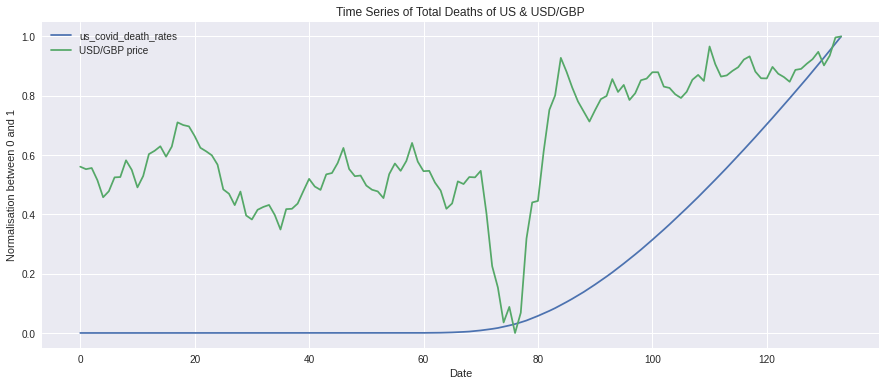

In [96]:
# Inspect the data
# Look at join distributions of afew pairs of collumns from the training set
# Need to revise what this graph does
import matplotlib.pyplot as plt
plt.title('Time Series of Total Deaths of US & USD/GBP')
plt.plot(normalisation_us_deaths,label="us_covid_death_rates")
plt.plot(normalisation_price, label="USD/GBP price")
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.legend() 
plt.show()

# Preprocessing the Data - Train & Test


In [97]:
new_dataset = np.hstack((normalisation_us_deaths,normalisation_price))
# new_dataset

In [98]:
# Test & Train split => Preprocessing the data 
# Splitting dataset into train and test split
# 65% of the total length of my datadrame
# 35% test size
# input: new_dataset instead of normalisation_us_deaths
training_size = int(len(new_dataset)*0.65)
# iterate through both and get 0th element of both and add to a list
test_size = (len(new_dataset)-training_size)//2
# rounds down //
train_data, test_data, valset_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(test_data.shape)
print(valset_data.shape)


(87, 2)
(23, 2)
(24, 2)


In [99]:
training_size, test_size

(87, 23)

In [100]:
len(train_data), len(test_data)

(87, 23)

In [101]:
# train_data

In [168]:
# Convert an array of values into a dataset matrix
# time_step = how many previous days you have to consider before making a prediction
# all data, need to split: [120,130,125,140,134,150,160,190,154,160,170]
# timesteps = 3
# train data = [120,130,125,140,134,150]
# test data = [160,190,154,160,170]
# X_train = f1,f2,f3
# f1 = [ [0.0000, 77777],  [0.0000,888] , [111, 9999], [111, 333499]]]
# Y_train = o/p
# f1  f2  o/p
# 120 130 125 
# 130 125 140 
# X_test = f1,f2,f3
# Y_test = o/p
# f1  f2  f3  o/p
# 160 190 154 160
# 190 154 160 170
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # then we subtract e.g. timestep=3 : lendataset -3-3 so you are shifting
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # i=0, 0,1,2,3
    # print(a)
    dataX.append(a)
    y = dataset[i + time_step][1] 
    dataY.append(y)
  return np.array(dataX), np.array(dataY)

In [172]:
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)
# print(X_train)
# print(Y_train)

In [103]:
# what does this mean? time_step is the number of days at the end
# taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)


In [171]:
# print(X_val)

In [105]:
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 7 features at a time f1,f2,f3,f4,f5,f6,f7
# print(X_train.shape)
# print(Y_train.shape)
# print(X_train)

In [106]:
print(X_test.shape), print(Y_test.shape)
# Finished preprocessing the data

(15, 7, 2)
(15,)


(None, None)

In [107]:
# Need to convert this to a 3D 
# reshape input to be [samples, time_steps, features] which is required for lstm
# therefore we add ,1 to convert to 3d
# 7,1 will be the input to our LSTM
# xtrain.shape = 79, 7, 1
# X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
# print("hi")
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

# Stacked LSTM Model

In [108]:
# Create the stacked LSTM model
# One LSTM after the other
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import InputLayer
model = Sequential()
# list: one element is a list of price and covid
# 1d with 2 values -> one can be price and covid
# model wont except tupils
# 2d input
# [[3,4],[4,5]]

# we want input_tensor to be a single data point
model.add(InputLayer(input_shape=(7,2)))
model.add(LSTM(5,return_sequences=True))
model.add(LSTM(5, return_sequences=True))
model.add(LSTM(5))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')




In [109]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 5)              160       
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 5)              220       
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 606
Trainable params: 606
Non-trainable params: 0
_________________________________________________________________


In [110]:
# Main aim should be to minimise the loss

model.fit(X_train, Y_train, 
          validation_data= 
          # last. no of values that may be used to valida
          # time series validation series
          # assign some validation data aside from test data you cant
          (X_val, Y_val)
          , epochs=100,batch_size=64,verbose=1)

Epoch 1/100
2/2 [==============================] - 1s 408ms/step - loss: 0.2931 - val_loss: 0.8018
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 0.2842 - val_loss: 0.7826
Epoch 3/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2754 - val_loss: 0.7637
Epoch 4/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2672 - val_loss: 0.7449
Epoch 5/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2589 - val_loss: 0.7262
Epoch 6/100
2/2 [==============================] - 0s 18ms/step - loss: 0.2508 - val_loss: 0.7073
Epoch 7/100
2/2 [==============================] - 0s 18ms/step - loss: 0.2426 - val_loss: 0.6882
Epoch 8/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2344 - val_loss: 0.6688
Epoch 9/100
2/2 [==============================] - 0s 18ms/step - loss: 0.2261 - val_loss: 0.6489
Epoch 10/100
2/2 [==============================] - 0s 17ms/step - loss: 0.2177 - val_loss: 0.6286
Epoch 11/100
2/2 [

# Predicted the test data 

*   Must also plot the output



In [111]:
# Prediction and check performance metric
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict.shape
test_predict.shape

(15, 1)

In [112]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
train_predict.shape

(79, 1)

In [113]:
# Calculate the RMSE performance metrics
# Output for the train dataset
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train, train_predict))

0.7524106991723682

In [114]:
# Similarly for the test Data RMSE
math.sqrt(mean_squared_error(Y_test, test_predict))

0.432629943268953

# Predicted future 7 days and plotted the output

(134, 2)
(134, 2)


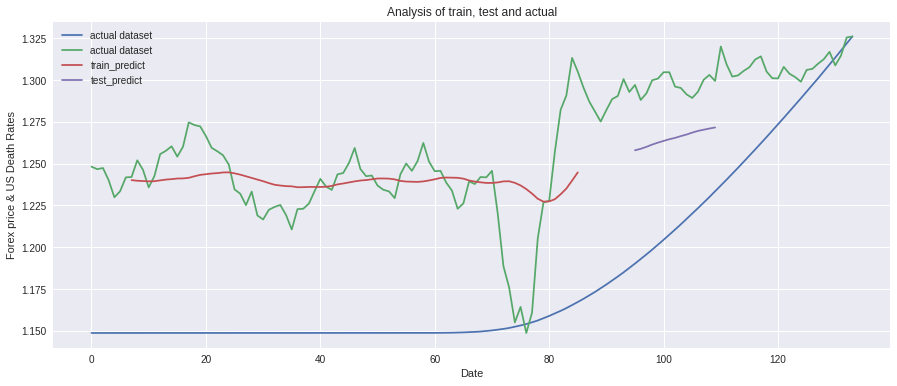

In [115]:
# Plotting
# Shift train predictions for plotting
# input is 7 days at a time
# and ..
look_back = 7

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)
# Shift test predictions for plotting
testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+2: (training_size + test_size)] = test_predict
# new_dataset[training_size:(training_size + test_size)]
print(testPredictPlot.shape)

# Plot baseline and predictions
plt.title('Analysis of train, test and actual')
plt.plot(scaler.inverse_transform(new_dataset), label="actual dataset")


trainPredictPlot = [item[1] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")
testPredictPlot = [item[1] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")


# as you can see th test data and train is divided because we want to test after a specific day
# plt.plot(testPredictPlot, label="test_predict")
plt.ylabel('Forex price & US Death Rates')
plt.xlabel('Date')
plt.legend()
plt.show()
# Printing 2 actual_dataset, train_predict, test_predict because 2 input layers

In [116]:
# Predict the future 30 days
# imagine in test data the last output was 23/may and you want to predict the 24/may
len(test_data) 

23

In [139]:
X_input=test_data[40:].reshape(1,-1)
X_input.shape


(1, 0)

In [140]:
# temp_input=list_arr(X_input)
# temp_input=temp_input[0].tolist()
# print(temp_input)
# print(X_input)
# should be: 
# [0.85895289 0.88202568 0.90535587 0.92874837 0.9523764  0.97612533
#  1.        ]
# error: 'numpy.ndarray' object is not callable
# for not:
# temp_input = [0.85895289,0.88202568,0.90535587,0.92874837,0.9523764,0.97612533,1.]
# print(temp_input)

temp_input = train_data[-7:]

In [141]:
temp_input

array([[0.05753473, 0.44532131],
       [0.0658916 , 0.61217587],
       [0.07456764, 0.75253664],
       [0.08383321, 0.80101466],
       [0.09400989, 0.92784667],
       [0.10444046, 0.88105975],
       [0.11526232, 0.82750846]])

In [167]:
# Demonstrate prediction for the next 4 days:
# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.

# Problem is with the Y-hat -> Outputting index 0, unable to access index 1

from numpy import array
lst_output=[]
n_steps=7
i=0
X_input = temp_input
# print(X_input)


while(i<4):
  # print(i, len(temp_input))
  if(len(temp_input)>7):
    # print(temp_input)  

    # Dont understand this code:
    # 7,7,7,7?????
    X_input=array(temp_input[1:])
    # print(X_input)

    # print("{} day input {}".format(i,X_input))

    # Correct input shape (1,7,2)
    X_input=X_input.reshape((1,n_steps,2))
    print(X_input)
    # Prediction of X_input
    Y_hat = model.predict(X_input)
    print(Y_hat)
  
    temp_input = np.append(temp_input, Y_hat)
    # print(temp_input)

    temp_input=temp_input[1:]

    #print(temp_input)
    lst_output.append(Y_hat[0][1])
    i=i+1

  else:
    X_input=X_input.reshape((1,n_steps,2))
    print(X_input)
    Y_hat = model.predict(X_input, verbose=0)
    temp_input = np.append(temp_input, Y_hat)
    # print(temp_input)
    lst_output.append(Y_hat[0][1])
    i=i+1

# Print the predicted forex price for the next 4 days 
print(lst_output)

[[[0.82750846 0.57801259]
  [0.68043691 0.5984832 ]
  [0.7078824  0.61942309]
  [0.72608781 0.64104474]
  [0.73737383 0.66492468]
  [0.74661648 0.68802482]
  [0.74974376 0.71369195]]]
[[0.75470704]]


IndexError: ignored

In [121]:
# 8 because we are moving one ahead of 7
day_new=np.arange(1,8)
# 12 because want to predict the next 4 days
day_pred=np.arange(8,12)

In [122]:
len(new_dataset)

134

In [123]:
df3=new_dataset.tolist()
df3.extend(lst_output)

ValueError: ignored

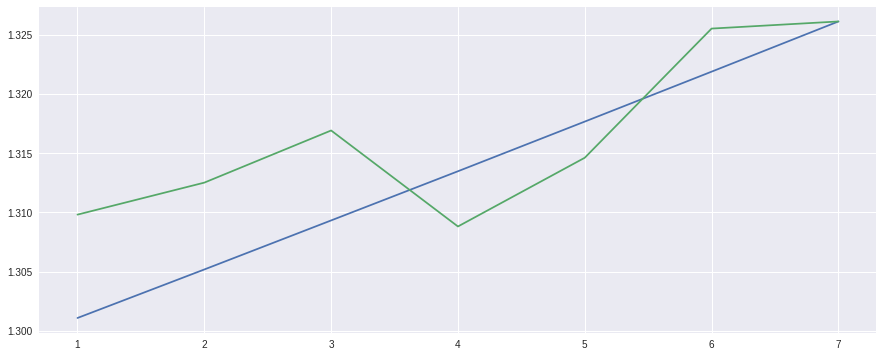

In [124]:
# the reason for 127 is that you are taking 134-7
plt.plot(day_new, scaler.inverse_transform(new_dataset[127:]))
# print the predicted next 4 days 
plt.plot(day_pred, scaler.inverse_transform(lst_output))

In [ ]:
# Combine actual and prediction
df3=normalisation_us_deaths.tolist()
df3.extend(lst_output)
plt.plot(df3[127:])

# Unsure why this isnt working
# Combine actual and prediction
# df3=new_dataset.tolist()
# df3.extend(lst_output)
# plt.plot(df3[127:])
# plt.plot(df3)

# Conclusion and next steps
We explored the LSTM algorithms:

*   List item
*   List item


In conclusion it seems that ..